In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
historical_data_start_date = "2021-07-01"

In [35]:
fixing_date = "2023-07-26"
time_format = "%Y-%m-%d"
asset_names = ["GOOGL UW Equity", "MSFT UW Equity", "AAPL UW Equity"]
df = pd.read_csv("stock_historical_prices.csv")
df.head(5)

,Dates,GOOGL UW Equity,MSFT UW Equity,AAPL UW Equity
0,2/10/2017,48.374,70.1074,36.494
1,3/10/2017,48.604,69.7785,36.653
2,4/10/2017,48.339,70.1826,36.416
3,5/10/2017,49.260,71.3853,36.869
4,6/10/2017,49.682,71.4135,36.847


In [36]:
from datetime import datetime
def preprocess_date(df):
   df["date"] = pd.to_datetime(df["Dates"], format = "%d/%m/%Y")


def calculate_returns(df, asset_names):
   for asset_name in asset_names:
      calculate_return(df, asset_name)

def calculate_return(df, asset_name: str):
   df[asset_name + "_return"] = np.log(df[asset_name] / df[asset_name].shift(1))


In [37]:
preprocess_date(df)
calculate_returns(df, ["GOOGL UW Equity", "MSFT UW Equity", "AAPL UW Equity"])

In [38]:
df

,Dates,GOOGL UW Equity,MSFT UW Equity,AAPL UW Equity,date,GOOGL UW Equity_return,MSFT UW Equity_return,AAPL UW Equity_return
0,2/10/2017,48.374,70.1074,36.494,2017-10-02,NaN,NaN,NaN
1,3/10/2017,48.604,69.7785,36.653,2017-10-03,0.004743,-0.004702,0.004347
2,4/10/2017,48.339,70.1826,36.416,2017-10-04,-0.005467,0.005774,-0.006487
3,5/10/2017,49.260,71.3853,36.869,2017-10-05,0.018874,0.016992,0.012363
4,6/10/2017,49.682,71.4135,36.847,2017-10-06,0.008530,0.000395,-0.000597
...,...,...,...,...,...,...,...,...
1322,26/10/2022,94.930,231.3200,149.350,2022-10-26,-0.095856,-0.080295,-0.019822
1323,27/10/2022,92.220,226.7500,144.800,2022-10-27,-0.028963,-0.019954,-0.030939
1324,28/10/2022,96.290,235.8700,155.740,2022-10-28,0.043187,0.039433,0.072834
1325,31/10/2022,94.510,232.1300,153.340,2022-10-31,-0.018659,-0.015983,-0.015530


## Abstract modelling class

In [39]:
from asset_model import AssetModel

## SingleAssetGBM

In [40]:
from single_asset_GBM import SingleAssetGBM

In [41]:
google = SingleAssetGBM(df, fixing_date, "GOOGL UW Equity")

In [42]:
cur_date = "2022-07-21"
google.get_predict_price(cur_date)

0.8165442512092946


7394.895881181734

In [43]:
google.r, google.v, google.sigma

(0.0006865235327487374, 0.0006865235327487374, 0.0185005775171534)

In [44]:
(1 + 0.0006865235327487374) ** 1000

1.98632854661763

<AxesSubplot:>

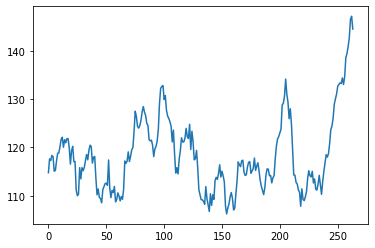

In [45]:
google.get_path(cur_date).plot()

## MultiAssetGBM

In [46]:
from multi_asset_GBM import MultiAssetGBM

In [47]:
multassetGBM = MultiAssetGBM(df, fixing_date, asset_names)

In [48]:

multassetGBM.get_predict_price(cur_date)

[ 1.44199516 -1.26965177  0.57845668]


GOOGL UW Equity_return    139.134774
MSFT UW Equity_return     353.048486
AAPL UW Equity_return     213.270842
dtype: object

In [49]:
multassetGBM.sigma

,GOOGL UW Equity_return,MSFT UW Equity_return,AAPL UW Equity_return
GOOGL UW Equity_return,0.018508,0.016499,0.016049
MSFT UW Equity_return,0.016499,0.018544,0.016883
AAPL UW Equity_return,0.016049,0.016883,0.020146


<AxesSubplot:xlabel='date'>

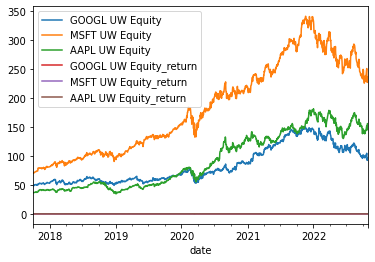

In [50]:
multassetGBM.df.plot()

<AxesSubplot:>

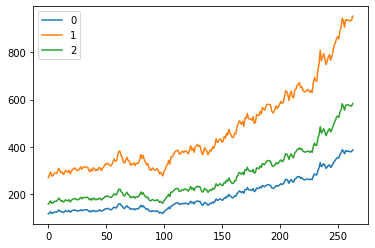

In [51]:
pd.DataFrame(multassetGBM.get_path(cur_date)).transpose().plot()

In [52]:
np.diag(multassetGBM.s_0)

array([[114.34, 0, 0],
       [0, 264.2791, 0],
       [0, 0, 155.135]], dtype=object)

In [53]:
w = np.random.normal(0, 1, (multassetGBM.no_of_assets,250))
multassetGBM.s_0 = multassetGBM.df.loc[cur_date, multassetGBM.asset_names]
return_path = np.exp(np.repeat([multassetGBM.v.values], [250], axis = 0).transpose() + multassetGBM.sigma.transpose().values @  w).cumprod(axis = 1)

In [54]:
return_path.shape

(3, 250)

In [55]:
cur_date

'2022-07-21'

In [56]:
sample_cols = ["GOOGL", "MSFT", "AAPL"]
multassetGBM.set_start_date(historical_data_start_date)
sample_df = pd.DataFrame(multassetGBM.get_path(cur_date).transpose(), columns = sample_cols, index = pd.bdate_range('2022-07-22', fixing_date, name = "date"))

<AxesSubplot:xlabel='date'>

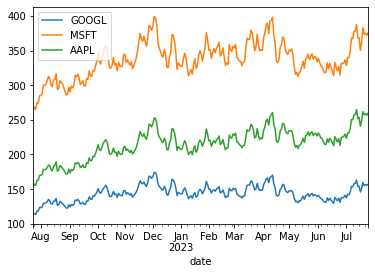

In [57]:
sample_df.plot()

In [58]:
# sample_df.to_csv("../generated_data/sample_path.csv")

## Generate Sample data (Nsim)

In [59]:

Nsim = 1000
samples = [pd.DataFrame(multassetGBM.get_path(cur_date).transpose(), columns = sample_cols, index = pd.bdate_range('2022-07-22', fixing_date, name = "date")) for i in range(Nsim)]

In [60]:
pd.Series([1] * 264)

0      1
1      1
2      1
3      1
4      1
      ..
259    1
260    1
261    1
262    1
263    1
Length: 264, dtype: int64

In [61]:
for i in range(Nsim):
    samples[i]["index"] = i

In [62]:
samples_df = pd.concat(samples)

In [63]:
samples_df.to_csv("../generated_data/sample_sim_1000.csv")

In [64]:
samples_df

,GOOGL,MSFT,AAPL,index
date,,,,
2022-07-22,115.448914,266.426132,155.975374,0
2022-07-25,112.925112,260.465917,152.309982,0
2022-07-26,113.138557,260.416992,152.36685,0
2022-07-27,111.856239,257.764593,150.462063,0
2022-07-28,115.917357,266.288019,155.022269,0
...,...,...,...,...
2023-07-20,127.269997,296.520212,198.695519,999
2023-07-21,129.441063,302.175223,202.513439,999
2023-07-24,131.499261,307.031882,205.781609,999
